<a href="https://colab.research.google.com/github/hiteshsurya17/hiteshsurya17-INFO-5731-Section-020---Computational-Methods-for-Information-Systems-Fall-2024-1-/blob/main/Hitesh_chowdary_suryadevara_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from scratch instead of using any pre-existing libraries to do so:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [12]:
import pandas as pd
import re
from collections import Counter
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


file_path = '/content/imdb_movie_reviews_with_analysis .csv'
data_df = pd.read_csv(file_path, usecols=[1], header=None, names=['text'])


def extract_ngrams(sentence, n):
    words = word_tokenize(sentence.lower())
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

trigram_freq = Counter()
for sentence in data_df['text']:
    trigrams = extract_ngrams(sentence, 3)
    trigram_freq.update(trigrams)

print("Trigram Frequencies:")
print(dict(trigram_freq))



def get_bigrams(sentence):
    words = word_tokenize(sentence.lower())
    bigrams = zip(words, words[1:])
    return [" ".join(bigram) for bigram in bigrams]

bigram_freq = Counter()
word_freq = Counter()

for sentence in data_df['text']:
    words = word_tokenize(sentence.lower())
    bigrams = get_bigrams(sentence)
    bigram_freq.update(bigrams)
    word_freq.update(words)

bigram_probabilities = {bigram: count / word_freq[bigram.split()[0]] for bigram, count in bigram_freq.items()}

print("\nBigram Probabilities:")
print(bigram_probabilities)



def find_noun_phrases(sentence):
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)
    phrases = []
    current_phrase = []

    for word, tag in pos_tags:
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            current_phrase.append(word)
        elif current_phrase:
            phrases.append(" ".join(current_phrase))
            current_phrase = []
    if current_phrase:
        phrases.append(" ".join(current_phrase))

    return phrases

phrase_counts = Counter()
for sentence in data_df['text']:
    phrases = find_noun_phrases(sentence)
    phrase_counts.update(phrases)

max_phrase_freq = max(phrase_counts.values())

phrase_relative_probabilities = []
for sentence in data_df['text']:
    review_phrase_counts = Counter(find_noun_phrases(sentence))
    review_probabilities = {phrase: (review_phrase_counts[phrase] / max_phrase_freq) for phrase in phrase_counts.keys()}
    phrase_relative_probabilities.append(review_probabilities)

output_df = pd.DataFrame(phrase_relative_probabilities)
output_df.index = [f"Review {i+1}" for i in range(len(data_df))]
output_df = output_df.fillna(0)

print("\nRelative Probabilities Table for Noun Phrases:")
print(output_df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Trigram Frequencies:
{'understand adapting cartoon': 2, 'adapting cartoon series': 2, 'cartoon series scene': 2, 'series scene scene': 4, 'scene scene live': 4, 'scene live adaptation': 2, 'live adaptation impractical': 2, 'adaptation impractical however': 2, 'impractical however removing': 2, 'however removing lead': 2, 'removing lead characters': 2, 'lead characters pivotal': 2, 'characters pivotal arc': 2, 'pivotal arc integral': 2, 'arc integral essence': 2, 'integral essence original': 2, 'essence original story': 2, 'original story weakens': 2, 'story weakens storytelling': 2, 'weakens storytelling aang': 2, 'storytelling aang portrayed': 2, 'aang portrayed lacks': 2, 'portrayed lacks innocence': 2, 'lacks innocence depth': 2, 'innocence depth yearold': 2, 'depth yearold protagonist': 2, 'yearold protagonist grew': 2, 'protagonist grew love': 2, 'grew love instead': 2, 'love instead hes': 2, 'instead hes presented': 2, 'hes presented young': 2, 'presented young adult': 2, 'young 

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any pre-existing libraries to do so.

In [13]:
import pandas as pd
import math
import re
from collections import Counter

file_path = '/content/imdb_movie_reviews_with_analysis .csv'
data_frame = pd.read_csv(file_path, usecols=[1], header=None, names=['text'])
docs = data_frame['text'].tolist()

def tokenize_text(text):
    cleaned_text = text.lower()
    cleaned_text = re.sub(r'[^a-z\s]', '', cleaned_text)
    return cleaned_text.split()

tokenized_texts = [tokenize_text(doc) for doc in docs]

def term_frequency(tokens):
    term_count = Counter(tokens)
    total_terms = len(tokens)
    return {term: count / total_terms for term, count in term_count.items()}

tf_values = [term_frequency(text) for text in tokenized_texts]

def inverse_document_frequency(tokenized_docs):
    total_docs = len(tokenized_docs)
    idf_scores = {}
    unique_terms = set([term for doc in tokenized_docs for term in doc])

    for term in unique_terms:
        docs_with_term = sum(1 for doc in tokenized_docs if term in doc)
        idf_scores[term] = math.log(total_docs / (1 + docs_with_term))

    return idf_scores

idf_scores = inverse_document_frequency(tokenized_texts)

tfidf_matrix = []
for tf in tf_values:
    tfidf_doc = {term: tf[term] * idf_scores[term] for term in tf.keys()}
    tfidf_matrix.append(tfidf_doc)

def compute_cosine_similarity(doc_vector, query_vector):
    dot_product = sum(doc_vector.get(term, 0) * query_vector.get(term, 0) for term in query_vector)

    doc_magnitude = math.sqrt(sum(value ** 2 for value in doc_vector.values()))
    query_magnitude = math.sqrt(sum(value ** 2 for value in query_vector.values()))

    if doc_magnitude == 0 or query_magnitude == 0:
        return 0

    return dot_product / (doc_magnitude * query_magnitude)

search_query = "An Outstanding movie with a haunting performance and best character development"
query_tokens = tokenize_text(search_query)

query_tf = term_frequency(query_tokens)
query_tfidf = {term: query_tf.get(term, 0) * idf_scores.get(term, 0) for term in idf_scores.keys()}

similarity_scores = [compute_cosine_similarity(tfidf_doc, query_tfidf) for tfidf_doc in tfidf_matrix]

ranked_docs = sorted(enumerate(similarity_scores), key=lambda x: x[1], reverse=True)

print("Ranked Documents based on Similarity to Query:")
for index, score in ranked_docs:
    print(f"Document {index + 1} (Score: {score:.4f}): {docs[index]}")


Ranked Documents based on Similarity to Query:
Document 512 (Score: 0.2142): loved original animated show quite looking forward live action since casting seemed miles better movieafter finishing episodes come conclusion indeed better movie pretty decent show alot room improvementswhile dallas liu gave outstanding performance prince zuko sadly gordon cormier kiawentiio aang katara gave weakest performance whole cast thats probably due lack experience lack good directing clear needed time guidance deliver lines emotions thought show needed improvements two characters heart series hope performance get better show gets second seasonthe things added live action thought great things thought didnt needed budget screentime could gone important things opinion director choose wisely budget needs go deserves screentimethe fight choreographies editing could use improvements well times fight scenes feel slow intense due editing visual effects pretty greatoverall quite enjoy season despite shortcomi

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


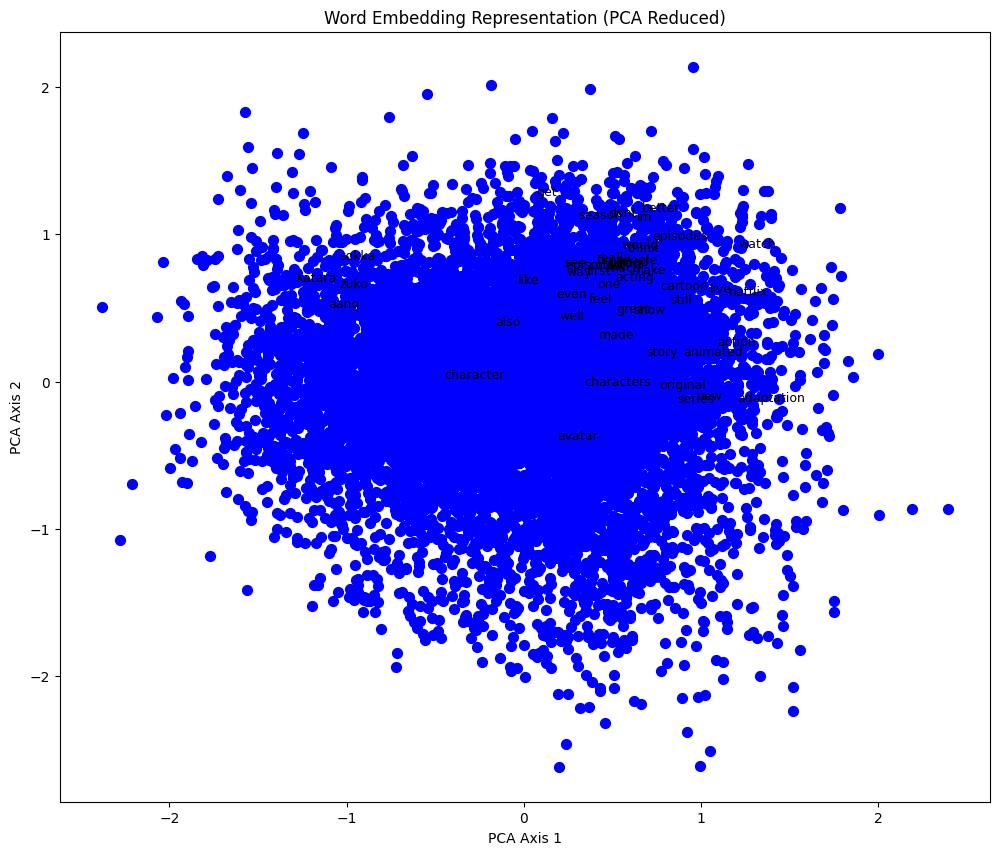

In [11]:
import pandas as pd
import re
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')


data_file = '/content/imdb_movie_reviews_with_analysis .csv'
dataframe = pd.read_csv(data_file, usecols=[1], header=None, names=['text'])

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return word_tokenize(text)

processed_reviews = [clean_and_tokenize(review) for review in dataframe['text']]

dimension_size = 300
embedding_model = Word2Vec(sentences=processed_reviews, vector_size=dimension_size, window=5, min_count=2, sg=1, epochs=50)

vocab_list = list(embedding_model.wv.index_to_key)
embedding_vectors = embedding_model.wv[vocab_list]

pca_reducer = PCA(n_components=2)
reduced_embeddings = pca_reducer.fit_transform(embedding_vectors)

plt.figure(figsize=(12, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', s=50)

for idx, word in enumerate(vocab_list[:50]):
    plt.annotate(word, xy=(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1]), fontsize=9)

plt.title("Word Embedding Representation (PCA Reduced)")
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.show()


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.


In [17]:
# The GitHub link of your final csv file


# Link:https://github.com/hiteshsurya17/hiteshsurya17-INFO-5731-Section-020---Computational-Methods-for-Information-Systems-Fall-2024-1-/blob/main/flipkart_reviews.csv



# Mandatory Question

Provide your thoughts on the assignment. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [18]:
''' I felt this assignment had ample time to complete and by practise this assignment felt more easier to
complete from the previous ones.
'''

' I felt this assignment had ample time to complete and by practise this assignment felt more easier to \ncomplete from the previous ones. \n'